# École Polytechnique de Montréal

Département Génie Informatique et Génie Logiciel
INF8460 – Traitement automatique de la langue naturelle

#### Prof. Amal Zouaq
#### Chargé de laboratoire: Félix Martel

# TP 3

## Objectifs

 - Implanter des modèles de classification neuronaux
 - Utiliser des plongements lexicaux pré-entrainés


## Travail à faire

Comme dans le TP précédent, on va travailler sur l'analyse de sentiment en utilisant les données du [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/).

Vous devez utiliser `scikit-learn` pour la régression logistique, et Keras pour les modèles neuronaux.

Les sections 1, 2 et 3 sont indépendantes.

Vous êtes libres d'appliquez les pré-traitements que vous jugerez utiles.

### 1. Pré-traitement et lecture de données

In [1]:
# Ici, vous devez lire vos données et appliquez les pré-traitements que vous jugerez utiles

# On fait comme dans le TP 2
!pip install --user nltk

import os
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

seq_train_neg = os.listdir("aclImdb/train/neg")
seq_train_pos = os.listdir("aclImdb/train/pos")

data_train_neg = [open("aclImdb/train/neg/" + file,encoding="utf-8").read() for file in seq_train_neg]
data_train_pos = [open("aclImdb/train/pos/" + file,encoding="utf-8").read() for file in seq_train_pos]
data_train = data_train_pos + data_train_neg

seq_test_neg = os.listdir("aclImdb/test/neg")
seq_test_pos = os.listdir("aclImdb/test/pos")

data_test_neg = [open("aclImdb/test/neg/" + file,encoding="utf-8").read() for file in seq_test_neg]
data_test_pos = [open("aclImdb/test/pos/" + file,encoding="utf-8").read() for file in seq_test_pos]
data_test = data_test_pos + data_test_neg

nb_doc_train = len(data_train)
nb_doc_test = len(data_test)

You should consider upgrading via the 'python -m pip install --upgrade pip' command.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mametc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mametc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mametc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
import nltk
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
import re

def segmentize(raw_text):
    """
    Segmente un document en phrases.

    >>> raw_corpus = "Alice est là . Bob est ici"
    >>> segmentize(raw_text)
    ["Alice est là .", "Bob est ici"]

    :param raw_text: str
    :return: list(str)
    """
    return nltk.sent_tokenize(raw_text)


def tokenize(sentences):
    """
    Tokenize une liste de phrases en mots.

    >>> sentences = ["Alice est là ", "Bob est ici"]
    >>> corpus = tokenize(sentences)
    >>> corpus_name
    [
        ["Alice", "est", "là "],
        ["Bob", "est", "ici"]
    ]

    :param sentences: list(str), une liste de phrases
    :return: list(list(str)), une liste de phrases tokenizées
    """
    res = []
    for sentence in sentences:
        res.append(nltk.word_tokenize(sentence))
    return res

def remove_unvalid_tokens(tokenized_text):
    """
    Remove the stopwords defined in nltk.corpus.stopwords from the given tokenized text.
    Nous devons enlever certains stopwords à la main.
    Remove non-alphabetic characters from the text.
    Remove one-character words from the text.
    
    :param tokenized_text: list(list(str)), une liste de listes de tokens
    :return: list(list(str)), une liste de listes de tokens, sans les tokens invalides
    """
    
    #On va rajouter le stopword 'br'
    stopwords.update(["br"])
    
    res = list()
    for sentence in tokenized_text:
        sentence_mod = list()
        for token in sentence:
             if token.lower() not in stopwords and re.fullmatch("[a-zA-Z]*",token)!=None and len(token) > 1:
                sentence_mod.append(token.lower())
        if sentence_mod != []:
            res.append(sentence_mod)
    return res

def clean_doc(corpus):
    tokens_preprocessed = []
    for documents in corpus:
        sentences = segmentize(documents)
        tokens = tokenize(sentences)
        tokens_clean = remove_unvalid_tokens(tokens)
        s = ""
        for x in tokens_clean:
            s += " " + " ".join(x) 
        tokens_preprocessed.append(s)
    return (tokens_preprocessed)


In [5]:
data_train_clean = clean_doc(data_train)

Dans la suite, vous allez entraîner deux modèles neuronaux : un perceptron multi-couche (MLP pour *multi-layer perceptron*), un réseau récurrent LSTM bi-directionnel. Pour cela, vous devrez utiliser la librairie [Keras](https://keras.io/).

N'hésitez pas à expérimenter différents hyper-paramètres pour obtenir le meilleur résultat possible sur au moins un de vos réseaux(nombre de couches, dimension des couches, etc.). Quelques pistes:

- optimisation des hyper-paramètres avec validation croisée (tous modèles)

- réduction de la dimension avec une LSA (MLP)

- ajout de couches/augmentation de la dimension/dropout ou autres changements d'architecture (MLP ou LSTM)

- pré-traitement différent (tous modèles)


<mark>Il est **fortement conseillé** d'utiliser une machine avec GPU</mark> pour entraîner ces modèles neuronaux. Vous pouvez utiliser les machines du labo L-4818 ou faire tourner votre notebook sur [Google Colab](https://colab.research.google.com) (gratuit).

### 2. Multi-layer Perceptron

**a)** Ici, on vous demande d'entraîner un perceptron multi-couches sur la matrice TF-IDF. Avant l'entraînement, affichez la structure du modèle avec `model.summary()`. Précisez la structure du réseau de neurones (taille et nombre de couches) et les paramètres d'entraînement (optimiseur, nombre d'époques, etc.).

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features = 5000)
X = vectorizer.fit_transform(data_train)


(24915, 5000)


In [106]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D, Bidirectional

In [157]:
model = Sequential([
            Dense(250, input_shape=(5000,), activation="relu"),
            Dense(1, activation="sigmoid")
            ])

model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
        )

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 250)               1250250   
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 251       
Total params: 1,250,501
Trainable params: 1,250,501
Non-trainable params: 0
_________________________________________________________________
None


In [158]:
y_train = [1 for i in range(len(data_train_pos))] + [0 for i in range(len(data_train_neg))]

In [159]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_acc', mode='max',patience=3)

history = model.fit(X, y_train,
                    validation_split = 0.1,
                    epochs=20,
                    batch_size=32,
                    callbacks=[es])

Train on 22423 samples, validate on 2492 samples
Epoch 1/20
22423/22423 [==============================] - 5s 242us/step - loss: 0.3317 - acc: 0.8591 - val_loss: 0.3255 - val_acc: 0.8559
Epoch 2/20
22423/22423 [==============================] - 3s 145us/step - loss: 0.2115 - acc: 0.9179 - val_loss: 0.3641 - val_acc: 0.8475
Epoch 3/20
22423/22423 [==============================] - 3s 144us/step - loss: 0.1785 - acc: 0.9300 - val_loss: 0.3331 - val_acc: 0.8680
Epoch 4/20
22423/22423 [==============================] - 3s 146us/step - loss: 0.1493 - acc: 0.9418 - val_loss: 0.3886 - val_acc: 0.8583
Epoch 5/20
22423/22423 [==============================] - 3s 145us/step - loss: 0.1159 - acc: 0.9565 - val_loss: 0.4727 - val_acc: 0.8443
Epoch 6/20
22423/22423 [==============================] - 3s 145us/step - loss: 0.0778 - acc: 0.9733 - val_loss: 0.5275 - val_acc: 0.8475


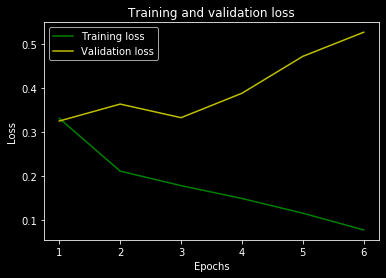

In [160]:
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

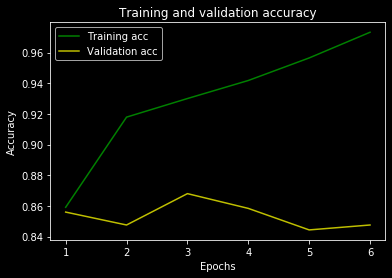

In [161]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 3. Bi-directional LSTM

**b)** Toujours avec Keras, entraînez un modèle bi-LSTM sur le corpus d'entraînement. Comme précédemment, affichez la structure du réseau et indiquez les paramètres utiles.

*Note :* si votre machine supporte CUDA, vous pouvez utiliser `keras.layers.CuDNNLSTM` au lieu de `keras.layers.LSTM` pour des gains de performance significatifs. Sur Google Colab, les environnements avec GPU supportent CUDA.

In [162]:
def clean_doc_lstm(corpus):
    tokens_preprocessed = []
    for documents in corpus:
        sentences = segmentize(documents)
        tokens = tokenize(sentences)
        tokens_clean = remove_unvalid_tokens(tokens)
        s = ""
        for x in tokens_clean:
            s += " " + " ".join(x) 
        tokens_preprocessed.append(s)
    return ["".join(x) for x in tokens_preprocessed]

In [164]:
X_train = clean_doc_lstm(data_train)

max phrase len: 1390


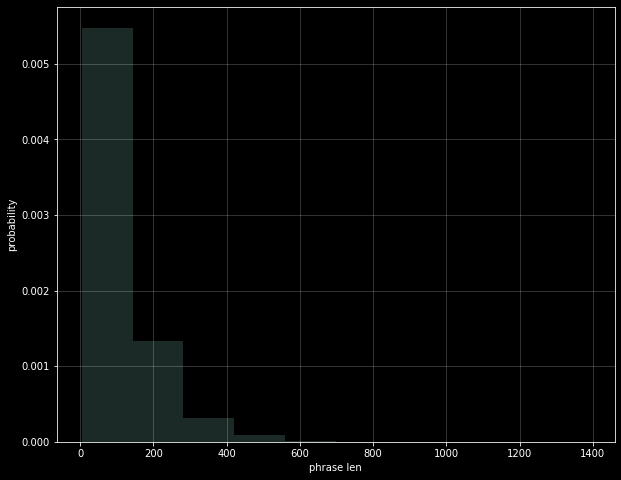

In [165]:
phrase_len = list(map((lambda p: len(p.split(' '))), X_train))
max_phrase_len = max(phrase_len)
print('max phrase len: {0}'.format(max_phrase_len))

plt.figure(figsize = (10, 8))
plt.hist(phrase_len, alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

In [166]:
max_words = 5000
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)

tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = 400)
y = to_categorical(y_train)

In [167]:
# On va ici utiliser une couche embedding non initialisée afin de réaliser un 
# codage one_hot sans subir une explosion de mémoire occupée

lstm_model = Sequential([
    Embedding(5000, 32, input_length=400, trainable= True),
    Bidirectional(LSTM(32,input_shape=(400,32),dropout = 0.3, recurrent_dropout = 0.3)), 
    Dense(2, activation="sigmoid")])

lstm_model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
        )

print(lstm_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 400, 32)           160000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 130       
Total params: 176,770
Trainable params: 176,770
Non-trainable params: 0
_________________________________________________________________
None


In [168]:
es = EarlyStopping(monitor='val_acc', mode='max',patience=3)

h = lstm_model.fit(
    X_train,
    y,
    validation_split = 0.1,
    epochs = 16,
    batch_size = 256,
    callbacks=[es]
)

Train on 22423 samples, validate on 2492 samples
Epoch 1/16
22423/22423 [==============================] - 107s 5ms/step - loss: 0.6286 - acc: 0.6404 - val_loss: 0.5882 - val_acc: 0.7606
Epoch 2/16
22423/22423 [==============================] - 106s 5ms/step - loss: 0.4095 - acc: 0.8385 - val_loss: 0.4557 - val_acc: 0.8264
Epoch 3/16
22423/22423 [==============================] - 104s 5ms/step - loss: 0.3415 - acc: 0.8637 - val_loss: 0.3905 - val_acc: 0.8381
Epoch 4/16
22423/22423 [==============================] - 102s 5ms/step - loss: 0.3164 - acc: 0.8743 - val_loss: 0.5865 - val_acc: 0.7657
Epoch 5/16
22423/22423 [==============================] - 105s 5ms/step - loss: 0.2933 - acc: 0.8841 - val_loss: 0.4924 - val_acc: 0.8166
Epoch 6/16
22423/22423 [==============================] - 103s 5ms/step - loss: 0.2730 - acc: 0.8955 - val_loss: 0.4041 - val_acc: 0.8483
Epoch 7/16
22423/22423 [==============================] - 103s 5ms/step - loss: 0.2670 - acc: 0.8962 - val_loss: 0.4772 - v

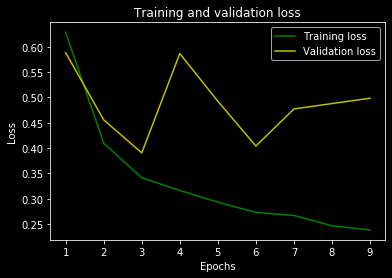

In [172]:
plt.clf()
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

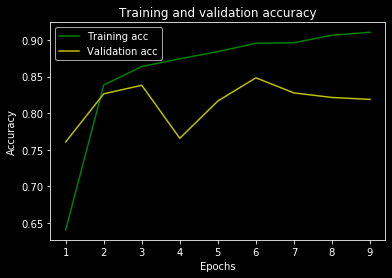

In [171]:
plt.clf()
acc = h.history['acc']
val_acc = h.history['val_acc']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**c) Word Embeddings**

Pour améliorer le modèle précédent, on va utiliser des *word embeddings* (ou plongements vectoriels) pré-entraînés. 

On utilisera un modèle Skip-gram de dimension $d=300$ entraîné sur English Wikipedia, disponible à l'adresse [http://vectors.nlpl.eu/explore/embeddings/en/models/](http://vectors.nlpl.eu/explore/embeddings/en/models/). Dans cette archive, vous trouverez les embeddings dans un fichier `.txt` tel que 
- la première ligne du fichier indique le nombre de mots dans le vocabulaire et la dimension des embeddings
- chacune des lignes suivantes est composée d'un mot_étiquette grammaticale suivi des 300 coordonnées de son *embedding*, le tout séparé par des espaces. 

Ainsi, les premières lignes de ce fichier sont :
```
296630 300
also_ADV -0.010121 -0.045202 -0.065609 ... -0.065423
one_NUM -0.060427 0.005032 -0.076370 ... -0.107769
first_ADJ 0.005799 0.024848 0.018902 ...  -0.097193
...
```

Les étiquettes `_ADV`, `_NUM`, `_ADJ`, etc. indiquent l'étiquette grammaticale du mot et peuvent être supprimées pour ce TP.

*Note :* vous pouvez utiliser le snippet suivant pour télécharger et dézipper automatiquement les embeddings (pratique si vous utilisez une machine distante comme Google Colab) :
```python
import requests
import io
from zipfile import ZipFile

res = requests.get("http://link/to/archive.zip")
with ZipFile(io.BytesIO(res.content)) as z:
  z.extractall("extract/to/dir/")
```


Implémentez un modèle bi-LSTM qui utilisent ces *embeddings* pour représenter les mots d'une phrase. Vous pourrez utiliser le layer [Embedding](https://keras.io/layers/embeddings/) de Keras.

Pour utiliser le modèle skip-gram, nous nous sommes basés sur le code suivant : https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [ ]:
dico_embed = dict()
with open("embeddings/model.txt","r",encoding="utf-8") as f:
    firstline = f.readline()
    for line in f:
        values = line.split()
        word = values[0].split("_")[0]
        coefs = np.asarray(values[1:], dtype = "float32")
        dico_embed[word] = coefs

temp = firstline.split()
nb_mots_embed = int(temp[0])
dim_embed = int(temp[1])

In [174]:
mat_embed = np.zeros((len(word_index)+1,dim_embed))
for word,i in word_index.items():
    temp = dico_embed.get(word)
    if temp is not None:
        mat_embed[i] = temp


In [175]:
lstm_model_embed = Sequential([
    Embedding(len(word_index)+1, dim_embed, input_length=400, weights=[mat_embed], trainable= False),
    Bidirectional(LSTM(32,input_shape=(max_phrase_len,32),dropout = 0.3, recurrent_dropout = 0.3)), 
    Dense(2, activation="sigmoid")])

lstm_model_embed.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
        )

print(lstm_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 400, 32)           160000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 130       
Total params: 176,770
Trainable params: 176,770
Non-trainable params: 0
_________________________________________________________________
None


In [176]:
es = EarlyStopping(monitor='val_acc', mode='max',patience=3)

h_embed = lstm_model_embed.fit(
    X_train,
    y,
    validation_split = 0.1,
    epochs = 16,
    batch_size = 256,
    callbacks=[es]
)

Train on 22423 samples, validate on 2492 samples
Epoch 1/16
22423/22423 [==============================] - 108s 5ms/step - loss: 0.6582 - acc: 0.6032 - val_loss: 0.6881 - val_acc: 0.6846
Epoch 2/16
22423/22423 [==============================] - 105s 5ms/step - loss: 0.5771 - acc: 0.7081 - val_loss: 0.7880 - val_acc: 0.6134
Epoch 3/16
22423/22423 [==============================] - 105s 5ms/step - loss: 0.5537 - acc: 0.7263 - val_loss: 0.5740 - val_acc: 0.7281
Epoch 4/16
22423/22423 [==============================] - 105s 5ms/step - loss: 0.5356 - acc: 0.7388 - val_loss: 0.5832 - val_acc: 0.7047
Epoch 5/16
22423/22423 [==============================] - 105s 5ms/step - loss: 0.5170 - acc: 0.7540 - val_loss: 0.6240 - val_acc: 0.6720
Epoch 6/16
22423/22423 [==============================] - 105s 5ms/step - loss: 0.5516 - acc: 0.7291 - val_loss: 0.4843 - val_acc: 0.7602
Epoch 7/16
22423/22423 [==============================] - 105s 5ms/step - loss: 0.5082 - acc: 0.7564 - val_loss: 0.5010 - v

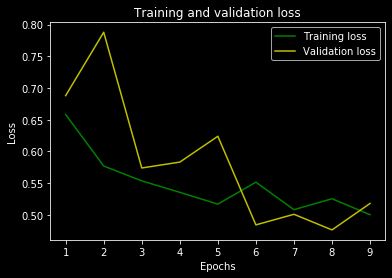

In [179]:
plt.clf()
loss = h_embed.history['loss']
val_loss = h_embed.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

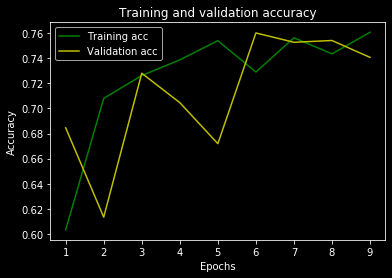

In [180]:
plt.clf()
acc = h_embed.history['acc']
val_acc = h_embed.history['val_acc']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 5. Évaluation

**d)** Indiquez les performances de chacun de vos modèles. Comparez avec les modèles Naive Bayes et character-LM du TP précédent et commentez.

Quel est votre meilleur modèle ?

In [197]:
X_test_perceptron = vectorizer.transform(data_test)
y_test_perceptron = [1 for i in range(len(data_test_pos))] + [0 for i in range(len(data_test_neg))]

X_test_lstm = clean_doc_lstm(data_test)
tokenizer.fit_on_texts(X_test_lstm)
X_test_lstm = tokenizer.texts_to_sequences(X_test_lstm)
X_test_lstm = pad_sequences(X_test_lstm, maxlen = 400)
y_test_lstm = to_categorical(y_test_perceptron)

21660
21660
21660
21660


In [156]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X, y_train)
score = classifier.score(X_test_perceptron, y_test_perceptron)

print("Accuracy:", score)

Accuracy: 0.8837950138504155


In [198]:
results_perceptron = model.evaluate(X_test_perceptron,y_test)

results_lstm = lstm_model.evaluate(X_test_lstm,y_test_lstm)

results_lstm_embed = lstm_model_embed.evaluate(X_test_lstm,y_test_lstm)

21660/21660 [==============================] - 375s 17ms/step


In [199]:
print("PERCEPTRON :       loss = ",results_perceptron[0],", accuracy = ",results_perceptron[1])
print("BI-LSTM :          loss = ",results_lstm[0],", accuracy = ",results_lstm[1])
print("BI-LSTM EMBEDDED : loss = ",results_lstm_embed[0],", accuracy = ",results_lstm_embed[1])

PERCEPTRON :       loss =  0.4959302401003305 , accuracy =  0.8531855955348451
BI-LSTM :          loss =  1.2700328925529896 , accuracy =  0.4991228070010329
BI-LSTM EMBEDDED : loss =  0.8152772817475203 , accuracy =  0.5062788550323176


Pour rappel, l'accuracy du modèle n-gram est de 0.82 sur les mêmes données.
Les modèles les plus simples (perceptron et régression logistique) obtiennent les meilleurs scores, ce qui est plutôt surprenant.


On peut imputer les basses performances des modèles sophistiqués au fait que nous n'avons pas exploré l'ensemble des hypers-paramètres, et au fait que les modèles ont clairement overfittés. On aurait utiliser une couche Drop-Out pour limiter cet overfitting.
On aurait pu plus particulièrement augmenter le nombre de couches dans les modèles LSTM.